In [1]:
from scipy.stats import qmc
import pandas as pd
import numpy as np
import time
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import random
import plotly.express as px
import plotly.graph_objects as go

caminho_do_projeto = r'C:\Users\kmenezes\OneDrive - unb.br\tcc_organizacao'

if caminho_do_projeto not in sys.path:
    sys.path.insert(0, caminho_do_projeto)

from projeto_aplicado.modelos.otimizador_ag import OtimizadorAG
from projeto_aplicado.modelos.otimizador_base import Otimizador
from projeto_aplicado.modelos.analisador import AnalisadorDeSolucao
from projeto_aplicado.modelos.otimizador_ag_fast import OtimizadorAGFast


# Configurações de visualização
sns.set_theme(style="whitegrid")
pd.set_option('display.max_rows', 100)

CONFIG_BASE = {
    "ARQUIVOS_DADOS": {
        "disciplinas": "disciplinas.csv",
        "professores": "docentes.csv",
        "preferencias": "preferencias.csv",
        "conflitos": "matriz_conflitos.csv" 
    }
}

#### Estudo de Convergência

In [ ]:
### Estudo de convergencia com variação de parâmetros do AG

# Domínios dos parâmetros a serem testados
DOM_N_POP      = [50, 80, 100, 120, 150, 180, 200]
DOM_T_CROSS    = (0.65, 0.95)     # uniforme
DOM_T_MUT      = (0.01, 0.18)     # uniforme
DOM_TORNEIO    = [2, 3, 4, 5]
DOM_ELITE      = [1, 2, 3, 4]

N_EXECUCOES = 10
resultados_execucoes = []
historicos = []
param_runs = []

for exec_id in range(N_EXECUCOES):
    CONFIG_AG_LONGO = {
    **CONFIG_BASE,
    "AG_PARAMS": {
        "n_populacao": random.choice(DOM_N_POP),
        "n_geracoes": 500,
        "taxa_crossover": random.uniform(*DOM_T_CROSS),
        "taxa_mutacao": random.uniform(*DOM_T_MUT),
        "tamanho_torneio": random.choice(DOM_TORNEIO),
        "fator_penalidade": 10000,
        "tamanho_elite": random.choice(DOM_ELITE)
    }
    }
    ag = OtimizadorAGFast(config=CONFIG_AG_LONGO)
    t0_global = time.time()
    res = ag.resolver()
    tempo_global = time.time() - t0_global

    df_hist = pd.DataFrame(res["metricas_iteracao"])
    df_hist["execucao"] = exec_id
    historicos.append(df_hist)
    
    # Infos finais
    melhor_global = res["valor_objetivo"]
    geracao_melhor = int(df_hist.loc[df_hist.melhor_geracao.idxmax(), "geracao"])
    total_geracoes = df_hist.geracao.max() + 1
    stagnation = int(df_hist.stagnation_count.iloc[-1]) if "stagnation_count" in df_hist.columns else None
    
    resultados_execucoes.append({
        "execucao": int(exec_id + 1),
        "melhor_fitness_final": int(melhor_global),
        "geracao_melhor_global": int(geracao_melhor),
        "tempo_total_execucao": tempo_global,
        "n_populacao": CONFIG_AG_LONGO['AG_PARAMS']['n_populacao'],
        "taxa_crossover": CONFIG_AG_LONGO['AG_PARAMS']['taxa_crossover'],
        "taxa_mutacao": CONFIG_AG_LONGO['AG_PARAMS']['taxa_mutacao'],
        "tamanho_torneio": CONFIG_AG_LONGO['AG_PARAMS']['tamanho_torneio'],
        "tamanho_elite": CONFIG_AG_LONGO['AG_PARAMS']['tamanho_elite']
    })

df_resumo = pd.DataFrame(resultados_execucoes)
df_hist_all = pd.concat(historicos, ignore_index=True)

df_resumo.to_csv('resultados_analises_simulacoes/ag_estudo_convergencia_resumo.csv', index=False)
df_hist_all.to_csv('resultados_analises_simulacoes/ag_estudo_convergencia_historico.csv', index=False)

Buscando dados no diretório: C:\Users\kmenezes\OneDrive - unb.br\tcc_organizacao\dados
Dados brutos carregados.
0 alocações fixas validadas e separadas.
28 de 28 professores responderam ao formulário.
Dados preparados. O problema foi reduzido para a otimização.
Otimizador base inicializado. 0 alocações foram fixadas.

--- Iniciando Processo de Otimização ---
--- Processo de Otimização Concluído ---
Buscando dados no diretório: C:\Users\kmenezes\OneDrive - unb.br\tcc_organizacao\dados
Dados brutos carregados.
0 alocações fixas validadas e separadas.
28 de 28 professores responderam ao formulário.
Dados preparados. O problema foi reduzido para a otimização.
Otimizador base inicializado. 0 alocações foram fixadas.

--- Iniciando Processo de Otimização ---
--- Processo de Otimização Concluído ---
Buscando dados no diretório: C:\Users\kmenezes\OneDrive - unb.br\tcc_organizacao\dados
Dados brutos carregados.
0 alocações fixas validadas e separadas.
28 de 28 professores responderam ao formulá

In [ ]:
## Lendo resultados salvos para evitar reexecução
df_hist_all = pd.read_csv('resultados_analises_simulacoes/ag_estudo_convergencia_historico.csv')
df_resumo = pd.read_csv('resultados_analises_simulacoes/ag_estudo_convergencia_resumo.csv')

In [ ]:
## Gráfico Plotly Análise da convergencia
col_best = "melhor_geracao"
limite_geracoes = 50

# Dados para o gráfico
df_plot = df_hist_all[df_hist_all["geracao"] < limite_geracoes].copy()

exec_ids = sorted(df_plot.execucao.unique())
n_exec = len(exec_ids)

gradient = px.colors.sequential.Viridis
cores = (gradient * ((n_exec // len(gradient)) + 1))[:n_exec]

fig = px.line(
    df_plot,
    x="geracao",
    y=col_best,
    color="execucao",
    line_group="execucao",
    template="simple_white",
    markers=False
)

# Legend names + colors
for tr in fig.data:
    exec_id = int(tr.name)
    tr.name = f"Sim {exec_id + 1}"
    tr.line.color = cores[exec_id]

# Calcular anotações (uma por curva) espalhadas ao longo de 5%..95% do range de gerações
max_gen = df_plot["geracao"].max()
min_gen = df_plot["geracao"].min()
ymin = df_plot[col_best].min()
ymax = df_plot[col_best].max()
label_positions = np.linspace(0.05, 0.95, n_exec)

annotations = []
vertical_jitter = ((ymax - ymin) * 0.01)  # pequeno deslocamento
for i, exec_id in enumerate(exec_ids):
    sub = df_plot[df_plot.execucao == exec_id].sort_values("geracao")
    gens = sub["geracao"].to_numpy()
    ys = sub[col_best].to_numpy()
    g_target = int(round((max_gen - min_gen) * label_positions[i] + min_gen))
    idx = np.argmin(np.abs(gens - g_target))
    g_sel = gens[idx]
    y_sel = ys[idx] + vertical_jitter  # ligeiro deslocamento para ficar acima
    annotations.append(dict(
        x=float(g_sel),
        y=float(y_sel),
        text=f"Sim {exec_id + 1}",
        showarrow=False,
        xanchor="center",
        yanchor="bottom",
        font=dict(color="black", size=11)
    ))

fig.update_layout(
#    annotations=annotations,
    legend_title_text="Simulações",
    legend=dict(
        orientation="v",
        yanchor="middle",
        y=0.5,
        xanchor="left",
        x=1.02,
        font=dict(size=11),
        bgcolor="rgba(255,255,255,0.0)"
    ),
    xaxis=dict(title="Geração", showgrid=False, zeroline=False),
    yaxis=dict(title="Melhor fitness da geração", showgrid=False, zeroline=False),
    margin=dict(l=50, r=150, t=10, b=50)
)

fig.write_image(
    "../graficos/ag_estudo_convergencia.pdf",
    format="pdf",
    width=900,   # largura em pixels (para PDF vira dimensão proporcional)
    height=450,  # altura
    scale=1
)

In [ ]:
## Salvando tabela resumo da convergência
col_map = {
    "execucao": "Simulação",
    "melhor_fitness_final": "Fitness Final",
    "geracao_melhor_global": "Geração Melhor",
    "tempo_total_execucao": "Tempo (s)",
    "n_populacao": "População",
    "taxa_crossover": "Crossover",
    "taxa_mutacao": "Mutação",
    "tamanho_torneio": "Torneio",
    "tamanho_elite": "Elite"
}

cols = [c for c in col_map if c in df_resumo.columns]
tabela = df_resumo[cols].rename(columns=col_map).sort_values("Simulação")

tabela.round(2).to_clipboard(index=False)

latex_str = tabela.to_latex(
    index=False,
    caption="Resumo das 10 execuções do algoritmo genético.",
    label="tab:ag_resumo",
    float_format="%.2f",
    escape=True
)



with open("../tabelas/ag_tabela_resumo_convergencia.tex", "w", encoding="utf-8") as f:
    f.write(latex_str)

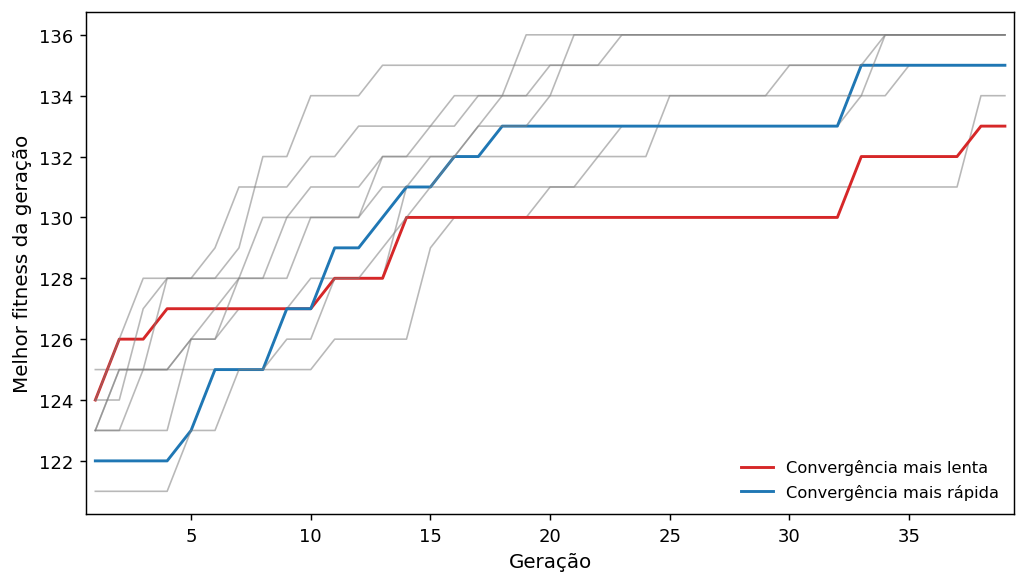

In [ ]:
## Gráfico Seaborn analise de convergência
exec_fast = 5
exec_slow = 2

# Plot limitado às primeiras 40 gerações
limite = 40
plt.style.use("default")
fig, ax = plt.subplots(figsize=(8, 4.6), dpi=130)

for exec_id in sorted(df_hist_all.execucao.unique()):
    sub = df_hist_all[(df_hist_all.execucao == exec_id) & (df_hist_all.geracao < limite)]
    y = sub["melhor_geracao"] if "melhor_geracao" in sub.columns else sub["melhor_fitness"]
    if exec_id == exec_fast:
        ax.plot(sub.geracao, y, color="#1f77b4", lw=1.6, label=f"Convergência mais rápida")
    elif exec_id == exec_slow:
        ax.plot(sub.geracao, y, color="#d62728", lw=1.6, label=f"Convergência mais lenta")
    else:
        ax.plot(sub.geracao, y, color="#7f7f7f", lw=0.9, alpha=0.55)

ax.set_xlabel("Geração", fontsize=11)
ax.set_ylabel("Melhor fitness da geração", fontsize=11)
ax.legend(frameon=False, fontsize=9, loc="lower right")

# Estilo científico limpo
ax.set_facecolor("white")
fig.patch.set_facecolor("white")
for spine in ax.spines.values():
    spine.set_color("black")
ax.grid(False)
ax.margins(x=0.01)

plt.tight_layout()
plt.show()

# (Opcional) salvar figura
#fig.savefig(f"../graficos/ag_convergencia.pdf", bbox_inches="tight")

#### Análise de Sensibilidade dos Parâmetros

In [28]:
df_resumo = pd.read_csv('resultados_analises_simulacoes/ag_estudo_sensibilidade_parametros_resumo.csv')
df_hist_all = pd.read_csv('resultados_analises_simulacoes/ag_estudo_sensibilidade_parametros_historico.csv')

In [46]:
df_resumo

,execucao,n_populacao,geracao_melhor_global,taxa_crossover,taxa_mutacao,tamanho_torneio,n_elitismo,melhor_fitness_final,tempo_total_seg,tempo_medio_por_geracao,tempo_ate_convergencia
0,1,494,16,0.143741,0.273805,9,123,136,50.098161,1.001963,16.031412
1,2,264,14,0.541592,0.067380,7,86,136,7.682043,0.153641,2.150972
2,3,162,16,0.680488,0.157854,8,55,136,11.134163,0.222683,3.562932
3,4,427,64,0.482969,0.303121,5,1,135,58.350607,1.167012,74.688777
4,5,262,13,0.650970,0.080098,9,60,136,8.594862,0.171897,2.234664
...,...,...,...,...,...,...,...,...,...,...,...
145,146,401,17,0.625026,0.029782,6,128,136,15.098556,0.301971,5.133509
146,147,31,62,0.246327,0.396295,4,13,135,8.142563,0.162851,10.096778
147,148,50,46,0.311953,0.368993,5,17,136,13.409889,0.268198,12.337098
148,149,179,57,0.419253,0.397124,4,80,136,44.328437,0.886569,50.534418


In [60]:
df_resumo['tempo_medio_por_geracao'] = df_resumo['tempo_total_seg'] / 50
df_resumo['tempo_ate_convergencia'] = df_resumo['tempo_medio_por_geracao'] * df_resumo['geracao_melhor_global']
df_resumo['elitismo_pct'] = df_resumo['n_elitismo'] / df_resumo['n_populacao']

In [47]:
df_resumo['melhor_fitness_final'].value_counts()

melhor_fitness_final
136    134
135     13
131      1
134      1
130      1
Name: count, dtype: int64

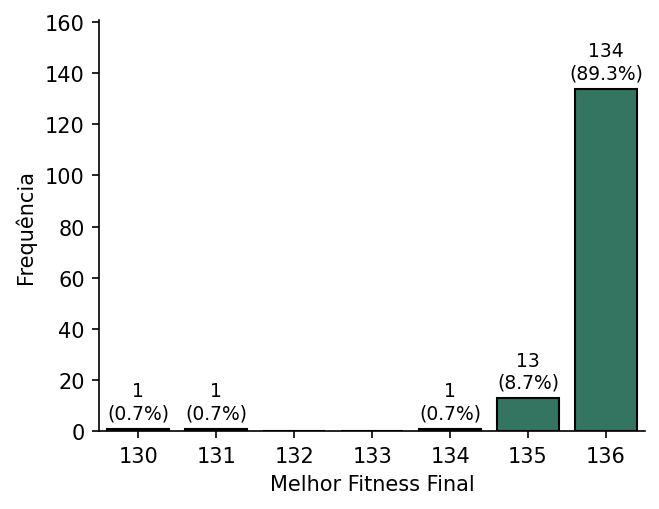

In [49]:
### Gráfico de barras da distribuição dos melhores fitness finais
freq_fitness = (
    df_resumo.groupby("melhor_fitness_final")
    .size()
    .reset_index(name="frequencia")
    .sort_values("melhor_fitness_final")
)

total = freq_fitness["frequencia"].sum()
freq_fitness["pct"] = 100 * freq_fitness["frequencia"] / total

min_fit = int(freq_fitness["melhor_fitness_final"].min())
max_fit = int(freq_fitness["melhor_fitness_final"].max())
todos_valores = pd.DataFrame({"melhor_fitness_final": range(min_fit, max_fit + 1)})

# Faz o merge para trazer as frequências e preenche NaN com 0
df_plot = pd.merge(todos_valores, freq_fitness, on="melhor_fitness_final", how="left").fillna(0)

# Recalcula a porcentagem baseada no total original
total = df_plot["frequencia"].sum()
df_plot["pct"] = 100 * df_plot["frequencia"] / total

# --- 2. PLOTAGEM ---
plt.style.use("default")
ig, ax = plt.subplots(figsize=(4.5, 3.5), dpi=150)# Ajustei levemente o tamanho

plot = sns.barplot(
    data=df_plot,
    x="melhor_fitness_final",
    y="frequencia",
    color="#298066",
    edgecolor="black",
    ax=ax
)

# --- 3. ANOTAÇÕES ---
# Iterar sobre os patches (barras) do eixo, que seguem a ordem do DataFrame df_plot
for i, p in enumerate(ax.patches):
    h = p.get_height()
    # Só anota se houver frequência > 0
    if h > 0:
        # Pega o valor correto do dataframe alinhado
        pct_val = df_plot.iloc[i]["pct"]
        label_text = f"{int(h)}\n({pct_val:.1f}%)"
        
        ax.annotate(label_text,
                    (p.get_x() + p.get_width()/2, h),
                    ha="center", va="bottom",
                    fontsize=9, color="black", 
                    xytext=(0, 3), textcoords="offset points")

# --- 4. ESTILO E EIXOS ---
# Removemos o set_xticks manual conflitante. 
# O Seaborn já coloca os rótulos baseados na coluna 'x'.

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

ax.grid(False)
ax.set_facecolor("white")


ax.set_xlabel("Melhor Fitness Final", fontsize=10)
ax.set_ylabel("Frequência", fontsize=10)

# Ajuste do limite Y para caber o texto
ax.set_ylim(0, df_plot["frequencia"].max() * 1.2)

plt.tight_layout()

plt.savefig("../graficos/ag_escores_calibracao_parametros.pdf",format="pdf", bbox_inches='tight')

In [50]:
### Tabela de frequências  de fitness para o resumo
tabela_freq = (
    df_resumo.groupby("melhor_fitness_final")
    .size()
    .reset_index(name="Frequencia_Absoluta")
    .sort_values("melhor_fitness_final")
).astype({"melhor_fitness_final": int, "Frequencia_Absoluta": int})
total = tabela_freq["Frequencia_Absoluta"].sum()
tabela_freq["Percentual (%)"] = 100 * tabela_freq["Frequencia_Absoluta"] / total

# 2. Renomear coluna para clareza
tabela_freq.rename(columns={"melhor_fitness_final": "Fitness_Final"}, inplace=True)
tabela_freq.to_clipboard(index=False)

In [ ]:
### Formatação e LaTeX do resumo das simulações (Apêndice)

# 2. Selecionar e renomear colunas (ajuste conforme necessidade)
col_map_apendice = {
    "execucao": "Simulacao",
    "n_populacao": "Populacao",
    "tamanho_torneio": "Torneio",
    "n_elitismo": "Elite",
    "taxa_crossover": "Taxa_Crossover",
    "taxa_mutacao": "Taxa_Mutacao",
    "geracao_melhor_global": "Geracao_Melhor",
    "melhor_fitness_final": "Fitness_Final",
    "tempo_total_seg": "Tempo_Seg"
}
cols_exist = [c for c in col_map_apendice if c in df_resumo.columns]

cols_int = ["execucao", "n_populacao", "tamanho_torneio", "n_elitismo", "melhor_fitness_final"]

for c in cols_int:
    if c in df_resumo.columns:
        df_resumo[c] = (
            pd.to_numeric(df_resumo[c], errors="coerce")  # força conversão numérica
              .round()                                     # caso venha float equivalente a int
              .astype("Int64")                             # tipo inteiro tolerante a NA
        )

t_apendice = (
    df_resumo[cols_exist]
    .rename(columns=col_map_apendice)
    .sort_values("Simulacao")
    .reset_index(drop=True)
)

# 3. Adicionar ranking por fitness (1 = melhor)
t_apendice["Rank_Fitness"] = t_apendice["Fitness_Final"].rank(method="dense", ascending=True).astype(int)

# 5. Formatação numérica
cols_float = ["Taxa_Crossover", "Taxa_Mutacao", "Tempo_Seg"]
for c in cols_float:
    if c in t_apendice.columns:
        t_apendice[c] = t_apendice[c].round(3)

# 7. Gerar LaTeX
latex_path = "../tabelas/ag_resumo_calibracao.tex"
latex_str = pd.DataFrame(t_apendice).to_latex(
    index=False,
    caption="Resumo organizado das execuções do AG (Apêndice).",
    label="tab:ag_resumo_apendice",
    escape=True,
    float_format="%.3f",
    column_format="rrrrrrrrrr"[:len(pd.DataFrame(t_apendice).columns)+1]  # simples ajuste
)
with open(latex_path, "w", encoding="utf-8") as f:
    f.write(latex_str)
print(f"LaTeX salvo em: {latex_path}")


LaTeX salvo em: ../tabelas/ag_resumo_calibracao.tex


In [54]:
df_resumo['tempo_ate_convergencia'].describe()

count    150.000000
mean      18.922106
std       23.530533
min        0.415800
25%        4.475380
50%        9.750390
75%       23.188688
max      121.353516
Name: tempo_ate_convergencia, dtype: float64

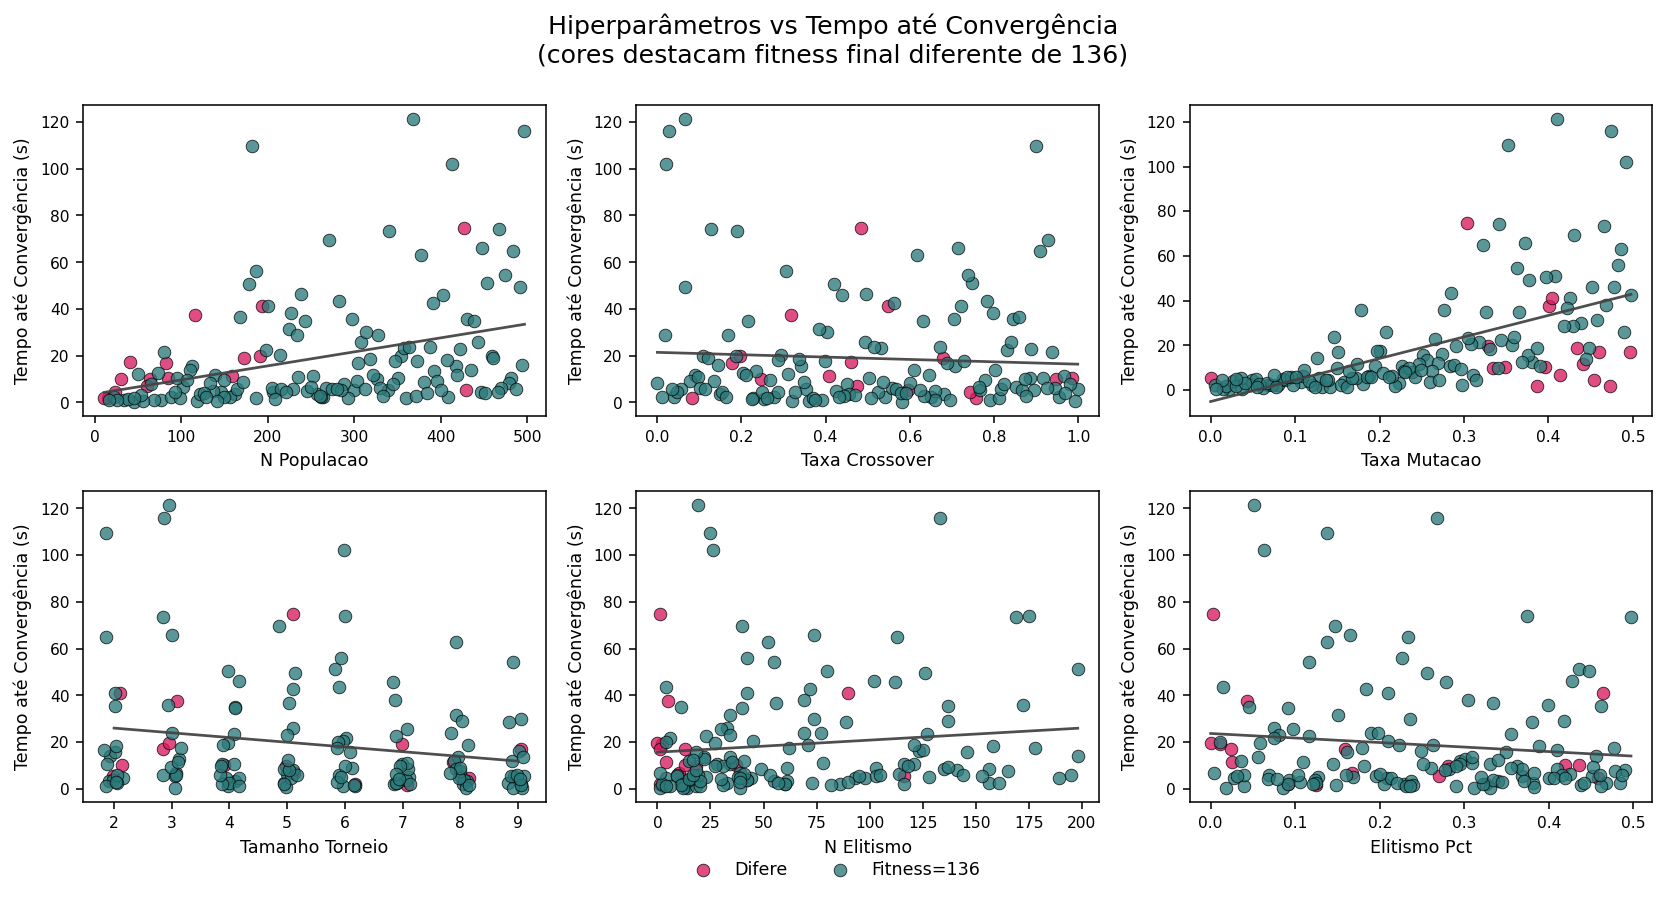

In [65]:
# ...existing code...
# Grid com cores: destaque para execuções com melhor_fitness_final diferente de 136
vars_x = [
    "n_populacao",
    "taxa_crossover",
    "taxa_mutacao",
    "tamanho_torneio",
    "n_elitismo",
    "elitismo_pct"
]

if "tempo_medio_por_geracao" not in df_resumo.columns:
    df_resumo["tempo_medio_por_geracao"] = df_resumo["tempo_total_seg"] / 50
if "tempo_ate_convergencia" not in df_resumo.columns:
    df_resumo["tempo_ate_convergencia"] = df_resumo["tempo_medio_por_geracao"] * df_resumo["geracao_melhor_global"]

TARGET_FIT = 136
df_resumo["flag_fit"] = np.where(df_resumo["melhor_fitness_final"] == TARGET_FIT, f"Fitness={TARGET_FIT}", "Difere")

cores = {
    f"Fitness={TARGET_FIT}": "#2C7A7B",
    "Difere": "#D81B60"
}

plt.style.use("default")
fig, axes = plt.subplots(2, 3, figsize=(12, 6.2), dpi=140)
axes = axes.flatten()

rng = np.random.default_rng(42)  # para jitter reprodutível

for ax, col in zip(axes, vars_x):
    y = df_resumo["tempo_ate_convergencia"]

    # Agrupar por flag de fitness
    for flag, sub in df_resumo.groupby("flag_fit"):
        x_plot = sub[col].copy()

        # Jitter apenas para tamanho_torneio (discreto) para evitar sobreposição
        if col == "tamanho_torneio":
            x_plot = x_plot + rng.uniform(-0.18, 0.18, size=len(x_plot))

        ax.scatter(
            x_plot, sub["tempo_ate_convergencia"],
            s=42,
            facecolor=cores[flag],
            edgecolor="black",
            alpha=0.78,
            linewidth=0.45,
            label=flag if ax is axes[0] else None  # evita duplicar legendas
        )

    # Linha reta (regressão linear simples) em vez de LOWESS
    x_full = df_resumo[col].astype(float)
    if x_full.nunique() > 1:
        # Para col discreto com poucos valores, usar média por valor (segmentos retos horizontais conectados)
        if x_full.nunique() <= 4:
            meio = (
                df_resumo.groupby(col)["tempo_ate_convergencia"]
                .mean()
                .reset_index()
                .sort_values(col)
            )
            ax.plot(meio[col], meio["tempo_ate_convergencia"],
                    color="#444444", lw=1.4, alpha=0.95)
        else:
            import numpy as np
            a, b = np.polyfit(x_full, y, 1)
            x_line = np.linspace(x_full.min(), x_full.max(), 60)
            y_line = a * x_line + b
            ax.plot(x_line, y_line, color="#444444", lw=1.4, alpha=0.95)

    ax.set_xlabel(col.replace("_", " ").title(), fontsize=9)
    ax.set_ylabel("Tempo até Convergência (s)", fontsize=9)
    ax.set_facecolor("white")
    for spine in ax.spines.values():
        spine.set_color("black")
    ax.grid(False)
    ax.tick_params(axis="both", labelsize=8)

# Legenda reposicionada abaixo para não colidir com o título
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="lower center",
    ncol=2,
    frameon=False,
    fontsize=9,
    bbox_to_anchor=(0.5, -0.02)
)

fig.suptitle(
    "Hiperparâmetros vs Tempo até Convergência\n(cores destacam fitness final diferente de 136)",
    fontsize=13,
    y=0.995
)
plt.tight_layout()
plt.show()
# ...existing code...

In [68]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [73]:
formula_gamma = "tempo_ate_convergencia ~ n_populacao + taxa_crossover + taxa_mutacao + tamanho_torneio + elitismo_pct"

# (2) Ajuste GLM Gamma (link log)
glm_gamma = smf.glm(
    formula=formula_gamma,
    data=df_resumo,
    family=sm.families.Gamma(sm.families.links.log())
).fit()
print("\n=== GLM Gamma (log link) ===")
print(glm_gamma.summary())


=== GLM Gamma (log link) ===
                   Generalized Linear Model Regression Results                    
Dep. Variable:     tempo_ate_convergencia   No. Observations:                  150
Model:                                GLM   Df Residuals:                      144
Model Family:                       Gamma   Df Model:                            5
Link Function:                        log   Scale:                         0.32232
Method:                              IRLS   Log-Likelihood:                -456.59
Date:                    Sat, 22 Nov 2025   Deviance:                       40.102
Time:                            15:22:30   Pearson chi2:                     46.4
No. Iterations:                        15   Pseudo R-squ. (CS):             0.9685
Covariance Type:                nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------

c:\Users\kmenezes\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning:

The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.



In [76]:
# (3) Modelo alternativo: regressão normal sobre log(tempo)
df_resumo["_log_tempo_conv"] = np.log(df_resumo["tempo_ate_convergencia"])
ols_log = smf.ols(
    formula="_log_tempo_conv ~ n_populacao + taxa_crossover + taxa_mutacao + tamanho_torneio + elitismo_pct",
    data=df_resumo
).fit()
print("\n=== OLS sobre log(tempo) (comparação) ===")
print(ols_log.summary())


=== OLS sobre log(tempo) (comparação) ===
                            OLS Regression Results                            
Dep. Variable:        _log_tempo_conv   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     139.9
Date:                Sat, 22 Nov 2025   Prob (F-statistic):           1.93e-53
Time:                        15:24:34   Log-Likelihood:                -113.65
No. Observations:                 150   AIC:                             239.3
Df Residuals:                     144   BIC:                             257.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [105]:
### Escolhendo parametros finais
CONFIG_AG_OPTIM = {
**CONFIG_BASE,
"AG_PARAMS": {
    "n_populacao": 45,
    "n_geracoes": 100,
    "taxa_crossover": 0.6,
    "taxa_mutacao": 0.02,
    "tamanho_torneio": 3,
    "fator_penalidade": 10000,
    "tamanho_elite": 14
}
}
ag = OtimizadorAGFast(config=CONFIG_AG_OPTIM)
t0_global = time.time()
res = ag.resolver()
tempo_global = time.time() - t0_global

Buscando dados no diretório: C:\Users\kmenezes\OneDrive - unb.br\tcc_organizacao\dados
Dados brutos carregados.
0 alocações fixas validadas e separadas.
28 de 28 professores responderam ao formulário.
Dados preparados. O problema foi reduzido para a otimização.
Otimizador base inicializado. 0 alocações foram fixadas.

--- Iniciando Processo de Otimização ---
--- Processo de Otimização Concluído ---


In [108]:
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np

# 1. Definir o que é Sucesso (Assumindo que seu fitness máximo é conhecido, ex: 0 penalidades)
# Substitua 'fitness_final' pelo nome da sua coluna e o valor pelo seu máximo
MAX_FITNESS = df_resumo['melhor_fitness_final'].max() 
df_resumo['sucesso_binario'] = (df_resumo['melhor_fitness_final'] == MAX_FITNESS).astype(int)

print(f"Total de Falhas: {len(df_resumo) - df_resumo['sucesso_binario'].sum()} de {len(df_resumo)} casos.")

# 2. Ajustar Regressão Logística
# Queremos saber: Quais parâmetros afetam a PROBABILIDADE de atingir o máximo?
formula_logit = "sucesso_binario ~ n_populacao + taxa_mutacao + tamanho_torneio + elitismo_pct"

logit_model = smf.logit(formula=formula_logit, data=df_resumo).fit()

print("=== Análise de Risco (Regressão Logística) ===")
print(logit_model.summary())

# 3. Interpretação Rápida (Odds Ratio)
params = logit_model.params
conf = logit_model.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%', 'Odds Ratio']
print("\nCoeficientes convertidos (Odds Ratio - >1 aumenta chance de sucesso):")
print(np.exp(conf))

Total de Falhas: 16 de 150 casos.
Optimization terminated successfully.
         Current function value: 0.216740
         Iterations 8
=== Análise de Risco (Regressão Logística) ===
                           Logit Regression Results                           
Dep. Variable:        sucesso_binario   No. Observations:                  150
Model:                          Logit   Df Residuals:                      145
Method:                           MLE   Df Model:                            4
Date:                Sat, 22 Nov 2025   Pseudo R-squ.:                  0.3616
Time:                        16:05:32   Log-Likelihood:                -32.511
converged:                       True   LL-Null:                       -50.923
Covariance Type:            nonrobust   LLR p-value:                 1.957e-07
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        

In [109]:
import numpy as np

# Coeficientes obtidos do seu modelo (image_9811b8.png)
intercepto = 1.1359
coef_pop = 0.0098
coef_mut = -10.2747
coef_torneio = 0.2662
coef_elitismo = 4.5136 # O p-valor foi marginal (0.059), mas vamos manter pois é positivo

# Cenário Base Otimizado (Minimizar custo, Maximizar pressão)
# Assumindo valores baseados nos seus gráficos anteriores
mutacao_fixa = 0.01       # Mínimo (já que ela atrapalha o sucesso e o tempo)
torneio_fixo = 9          # Máximo (pressão seletiva ajuda)
elitismo_pct_fixo = 0.5   # Máximo (ou o valor máx da sua escala, ex: 0.5 se for 50%)

# Qual a probabilidade de segurança que você quer? (ex: 99%)
probabilidade_alvo = 0.99
logit_alvo = np.log(probabilidade_alvo / (1 - probabilidade_alvo))

# Isolando N_Populacao na equação da regressão logística:
# logit = intercept + (b_pop * N) + (b_mut * mut) + (b_torn * torn) + (b_eli * eli)
# N = (logit - intercept - outros_termos) / b_pop

termos_fixos = (coef_mut * mutacao_fixa) + (coef_torneio * torneio_fixo) + (coef_elitismo * elitismo_pct_fixo)
n_populacao_seguranca = (logit_alvo - intercepto - termos_fixos) / coef_pop

print(f"=== Cálculo da Fronteira de Eficiência ===")
print(f"Para garantir {probabilidade_alvo*100}% de probabilidade de sucesso,")
print(f"mantendo Mutação em {mutacao_fixa} e Torneio em {torneio_fixo}:")
print(f"\nPopulação Mínima Necessária: {n_populacao_seguranca:.2f}")

=== Cálculo da Fronteira de Eficiência ===
Para garantir 99.0% de probabilidade de sucesso,
mantendo Mutação em 0.01 e Torneio em 9:

População Mínima Necessária: -111.29
